In [59]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier
import lightgbm as lgb
import joblib
import logging
import optuna
from causalml.metrics.visualize import get_cumgain
from causalml.metrics import auuc_score
from copy import deepcopy


%load_ext autoreload
%aimport plotMethods
%autoreload 1

np.random.seed(42) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Uplift modeling - which customers to target?

Modern world is full of advertisements and those are becoming more and more targeted. To win our attention, companies adapt to e.g. our digital viewing habits, collect our demographic data and then use this information to sell us things they think we may like. By focusing on specific traits, interests and preferences of a customer, targeted marketing is trying to **maximize the incremental impact of the promoted product**.

But how do these marketing campaigns identify the right individuals to send discount coupons or personalized advertisements to? Certainly, running those campaigns incurs financial costs, and it is unfeasible to send discount coupons to everyone in the world. The cost of printing the coupons and the lost of potential revenues, resulting from the offered discount, might just outweigh the additional profits generated from new customers. In addition, what if the customer was already planning to buy the advertised coupon, without receiving any extra discounts or adverts? In that case, the retailer would generate less profit, as the customer will be paying less than what they already intended to pay. So how do you identify individuals who are **only likely to purchase** your product **if targeted by the marketing campaign**?

## Dataset

Here, we will be using data provided by *Udacity* as part of their *Data Scientist Nanodegree*. This dataset was originally used as a take-home assignment given out by Starbucks during job application process. The data consists of about 120,000 data points split in a 2:1 ratio between training and testing sets. In the experiment, simulated by the data, Starbucks is about to launch a new marketing campaign based on sending promotional materials to selected customers. The team has run a randomized pilot (A/B testing) to test this campaign. In the pilot, a subset of customers was divided into two groups, only one of which received the promotion. The team recorded each customer's buying decision along with 7 features (*V1-V7*) encoding their personal characteristics. Based on the gathered data, we now want to know which other customers should be assigned to this campaign, in a way that would maximize generated profit. Since it costs the company *0.15* to contact each person, it would be best to limit the campaign only to the most receptive customers. As such, rather than predicting which customers would buy the product, we want to predict which customers would buy the product **only if contacted** (interaction).

## Goal

Our goal is to maximize the **profit of the campaign**:

$profit = \sum \limits _{i=1} ^{N} 10*purchase_{i}(decision_{i}) - 0.15*decision_{i}$,

where *purchase* is a purchasing decision of an individual client influenced by the *decision* - a binary indicator of whether that person has been targeted or not.

To account for the fact that some customers buy the product even if not targeted, we should also look at the **net incremental profit**, defined as:

$NIR = profit-10*nControlPurchase$,

where *nControlPurchase* is the number of people, who were not targeted and bought the service.

Furthermore, Starbucks asked their job candidates to also optimize the **incremental response rate**, defined as:

$IIR = \frac{nTreatPurchase}{nTreat} - \frac{nControlPurchase}{nControl}$, 

where *nTreatPurchase* is the number of people, who were not targeted and bought the service; and *nTreat* and *nControl* are the number of targeted and non-targeted customers respectively.

For this assignment, Starbucks claimed to have a model that achieved a NIR of 189.45 and an IRR of 1.88%. Note that this assignment is quite outdated though and it is very likely that Starbucks will have a better model now! Yet, these numbers will serve us as the benchmarks to beat.

## The approach

The problem of deciding whether it is profitable to target a particular customer can be tackled from two different perspectives:

1. traditional predictive modeling, where the problem is treated as a common classification task
2. uplift modeling, where the incremental probability of purchase is modeled

Here, we're gonna compare both of those perspectives and use a total of four different approaches to choosing which customers to target:

1. [Traditional predictive model](./1.Classical-predictive-models.ipynb) 
2. [S-learner model (one-model "uplift classifier")](./2.S-learner.ipynb) 
3. T-learner model (two-models "uplift classifier")
4. Direct uplift modeling

# T-learner (two-models uplift classifier)

In this approach, we will build two separate models, predicting the probability of a given customer buying our product. First model will be trained solely on the observations coming from the targeted group (*T(X)*), and the second one solely on the observations from the non-targeted, control group (*C(X)*). We will then fit both of these models to our new dataset and calculate our uplift as the difference in probabilities predicted by treatment model and the control model:

$Uplift = T(X) - C(X)$

In [3]:
data = pd.read_csv("data/training.csv")
data['Promotion'] = data['Promotion'].replace({'No': 0, 'Yes': 1})

## Exploratory Data Analysis

First, we need to learn a little bit more about our data - what type of variables are we working with, how many data points do we have, do we have to deal with any missing data etc. 

In [4]:
plotMethods.eda(data)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
ID,int64,84534,0,84534,62970.972413,36418.440539,1.000000,126184.000000,-1.199707,0.005485
Promotion,int64,84534,0,2,0.501147,0.500002,0.000000,1.000000,-2.000026,-0.004590
purchase,int64,84534,0,2,0.012303,0.110234,0.000000,1.000000,76.299732,8.848612
V1,int64,84534,0,4,1.500662,0.868234,0.000000,3.000000,-0.673422,0.000404
V2,float64,84534,0,84518,29.973600,5.010626,7.104007,50.375913,0.021425,-0.011369
V3,float64,84534,0,40,0.000190,1.000485,-1.684550,1.691984,-1.205420,0.004073
V4,int64,84534,0,2,1.679608,0.466630,1.000000,2.000000,-1.407398,-0.769828
V5,int64,84534,0,4,2.327643,0.841167,1.000000,4.000000,-0.743953,-0.059024
V6,int64,84534,0,4,2.502898,1.117349,1.000000,4.000000,-1.358416,-0.003446
V7,int64,84534,0,2,1.701694,0.457517,1.000000,2.000000,-1.222616,-0.881710


We have 11 variables - 7 Vs corresponding to customers' features, an information on whether the customer has been targeted in the A/B test (Promotion), customer's purchase decision (purchase), customer's ID and finally the (added) target variable indicating whether the customer should be target in the new marketing campaign. The customer ID should be a random value assigned to the customer for identification purposes, it won't be helpful to us here. We have **no categorical features** and **no missing data**, we do have a couple of **binary variables** and 3 further **integer variables**, that may potentially be ordinal. The features are. not labeled purposefully, as Strabucks wanted the job candidate to focus solely on the analytical process without being able to benefit from business insights. 

But before we take a closer look at all that, let's check our **Promotion** and **purchase** columns. What is the outcome of our A/B testing? Is our marketing campaign working?

In [4]:
data.columns = ['ID', 'promotion', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

chi, p, _, _ = stats.chi2_contingency(pd.crosstab(data['purchase'], data['promotion']))
print("\n Chi square test of independence - chi2: {}, p-value: {} \n".format(chi, p))
origProfit = pd.crosstab(data['purchase'], data['promotion'], margins=True, margins_name="total")
origProfit


 Chi square test of independence - chi2: 154.6851420820884, p-value: 1.6405910232768956e-35 



promotion,0,1,total
purchase,,,
0,41851,41643,83494
1,319,721,1040
total,42170,42364,84534


All right, so from our group of 84534 customers, approximately 50% (42364) were targeted during the A/B testing. Out of those about 2% (721) purchased the product. Additional 319 purchases were made by non-targeted customers (~1% of all non-targeted customers). Statistical testing *(chi square test of independence)* reveals that there is a **significant relationship between the purchase and treatment variables**, suggesting that the new campaign is indeed working. 

What is important to note is that we are working with a **highly imbalanced dataset**. This is going to affect the metric we choose for model evaluation. We may also want to upsample/downsample our data.

Let's have a look at what profit generated by this campaign.

In [6]:
profit = 10*1040 - 0.15*42364
NIR = profit - 10*319
IIR = 721/42364 - 319/41851

print("profit: {:.2f}, NIR: {:.2f}, IIR: {:.2f}%".format(profit, NIR, IIR*100))

profit: 4045.40, NIR: 855.40, IIR: 0.94%


The campaign generated a NIR of 855.4 and IIR of 1%. Can we do better?

Let's also have a closer look at the distributions of our variables.

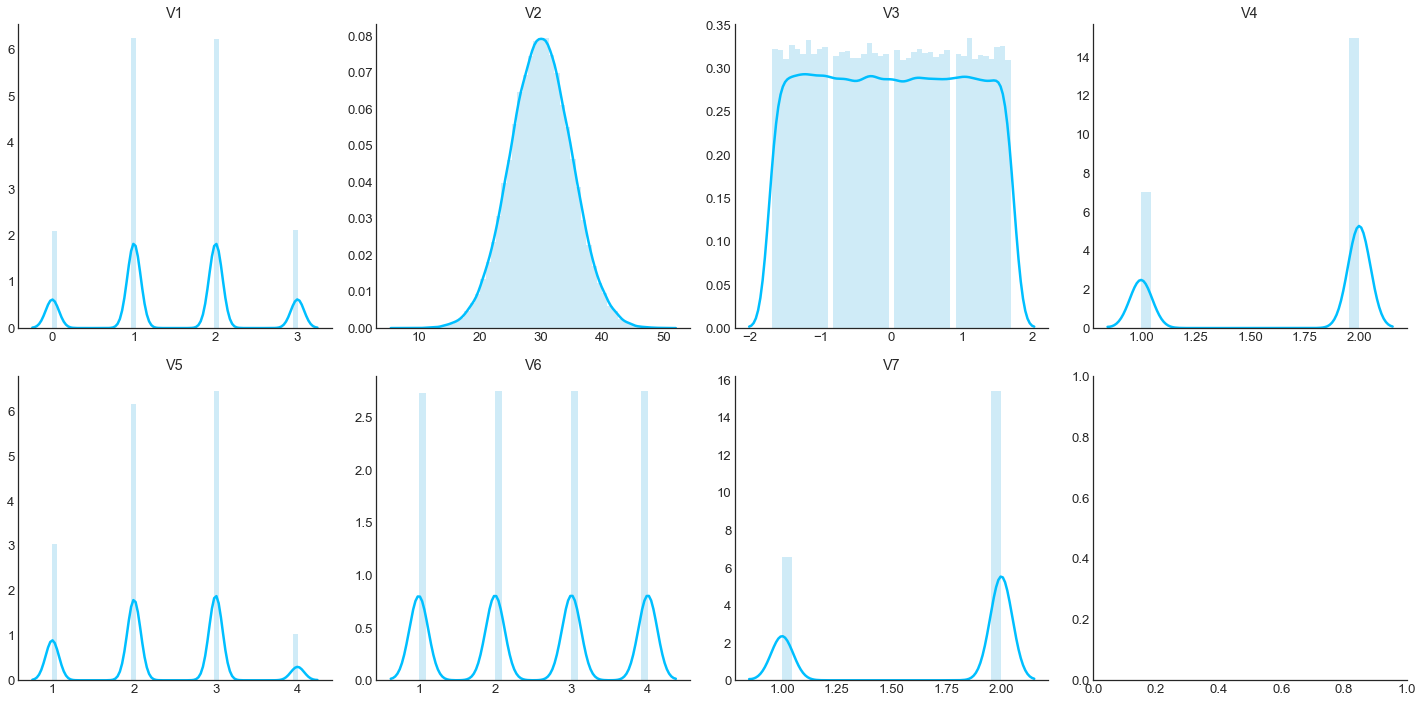

In [10]:
f, axes = plt.subplots(2, 4, figsize=(20,10), sharex=False)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.style.use("seaborn-white")
for ax, feature in zip(axes.flat, list(data.iloc[:,3:].select_dtypes(exclude='object').columns)):
    sns.distplot(data[feature], kde_kws = {"color": "deepskyblue"}, 
                 hist_kws = {"color": "skyblue"}, ax=ax)
    sns.despine()
    ax.set(title=feature)
    ax.set(xlabel=None)
plt.tight_layout()

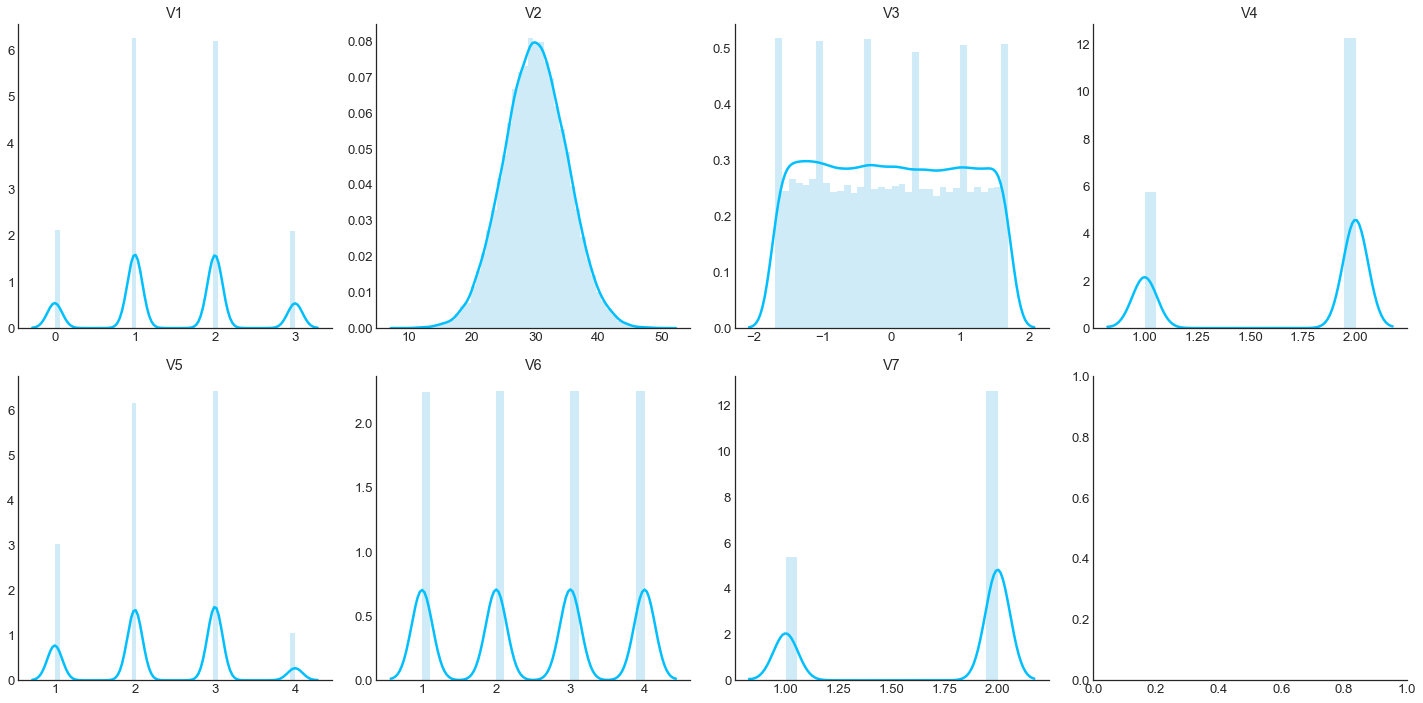

In [16]:
# Control group
f, axes = plt.subplots(2, 4, figsize=(20,10), sharex=False)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.style.use("seaborn-white")
for ax, feature in zip(axes.flat, list(data.iloc[:,3:].select_dtypes(exclude='object').columns)):
    sns.distplot(data.query("promotion==0")[feature], kde_kws = {"color": "deepskyblue"}, 
                 hist_kws = {"color": "skyblue"}, ax=ax)
    sns.despine()
    ax.set(title=feature)
    ax.set(xlabel=None)
plt.tight_layout()

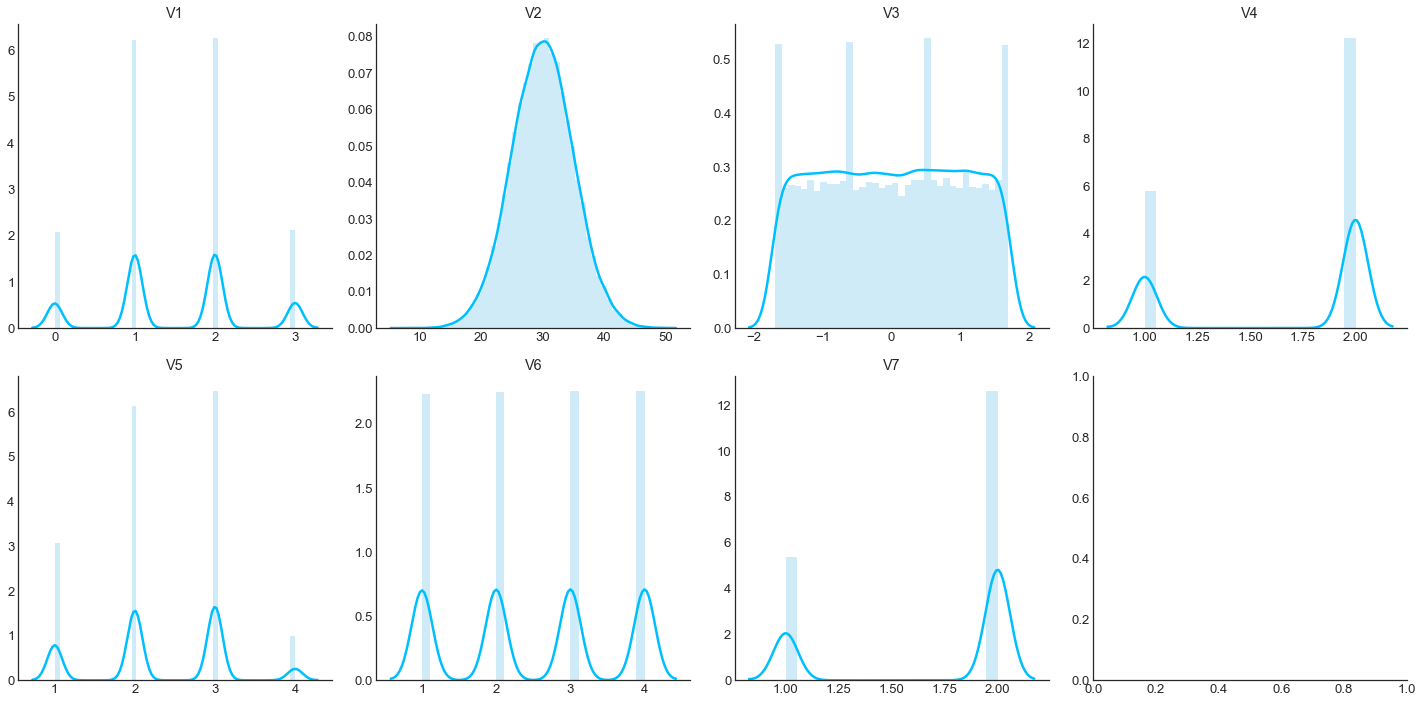

In [17]:
# Treatment
f, axes = plt.subplots(2, 4, figsize=(20,10), sharex=False)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.style.use("seaborn-white")
for ax, feature in zip(axes.flat, list(data.iloc[:,3:].select_dtypes(exclude='object').columns)):
    sns.distplot(data.query("promotion==1")[feature], kde_kws = {"color": "deepskyblue"}, 
                 hist_kws = {"color": "skyblue"}, ax=ax)
    sns.despine()
    ax.set(title=feature)
    ax.set(xlabel=None)
plt.tight_layout()

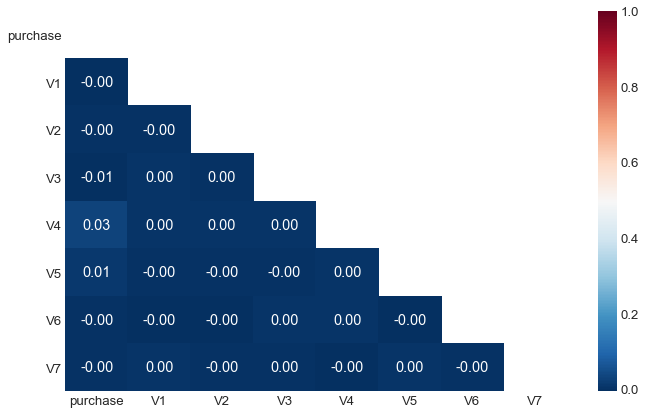

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
mask = np.triu(data.iloc[:,2:].corr()) # mask to display only lower triangle of the heatmap
sns.heatmap(data.iloc[:,2:].corr(method='spearman'), annot=True, mask=mask, ax=ax, fmt=".2f", cmap="RdBu_r")

From the heatmap, we can see that most of the numerical are rather poorly correlated with our target variable *toTarget*. We can also see that there is very little colinearity between the features themselves.

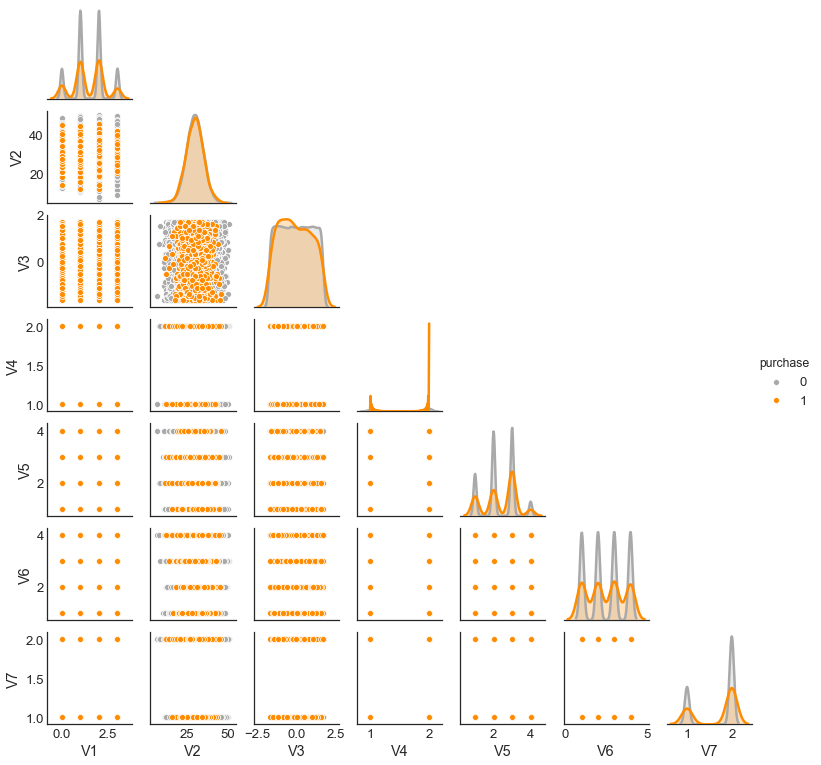

In [13]:
g = sns.pairplot(data, vars=list(data.iloc[:,3:].select_dtypes(exclude='object').columns), 
                 hue="purchase", corner=True, height=1.5, palette = {0: 'darkgray', 1: 'darkorange'})

V1,0,1,2,3
purchase,,,,
0,10487,31241,31203,10563
1,138,390,405,107


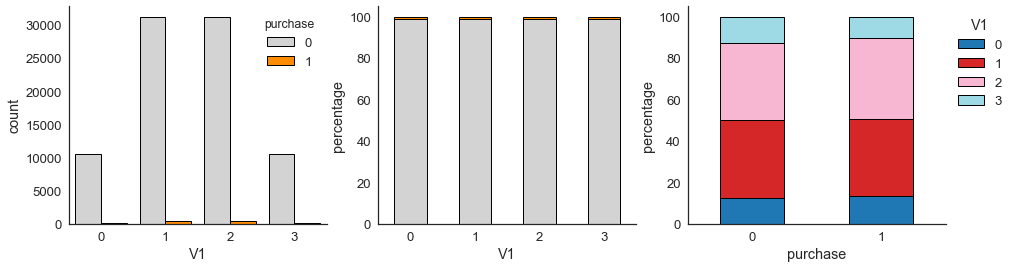

In [178]:
crossV1 = pd.DataFrame(pd.crosstab(data['V1'], data['purchase'], normalize="index")*100)
crossV1target = pd.DataFrame(pd.crosstab(data['V1'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V1'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V1", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV1.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV1target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V4,1,2
purchase,,
0,26891,56603
1,193,847


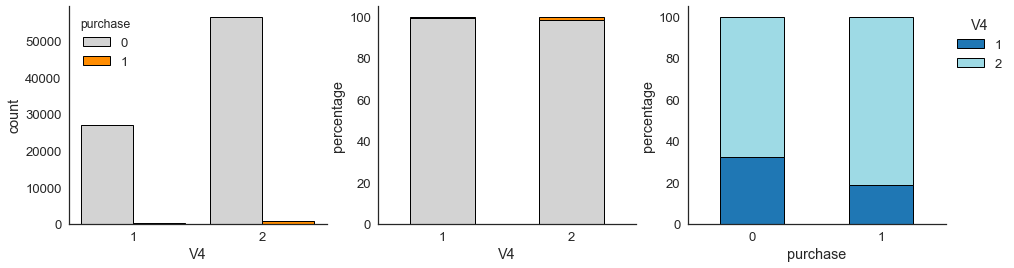

In [179]:
crossV4 = pd.DataFrame(pd.crosstab(data['V4'], data['purchase'], normalize="index")*100)
crossV4target = pd.DataFrame(pd.crosstab(data['V4'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V4'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V4", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV4.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV4target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V5,1,2,3,4
purchase,,,,
0,15201,30915,32260,5118
1,211,281,483,65


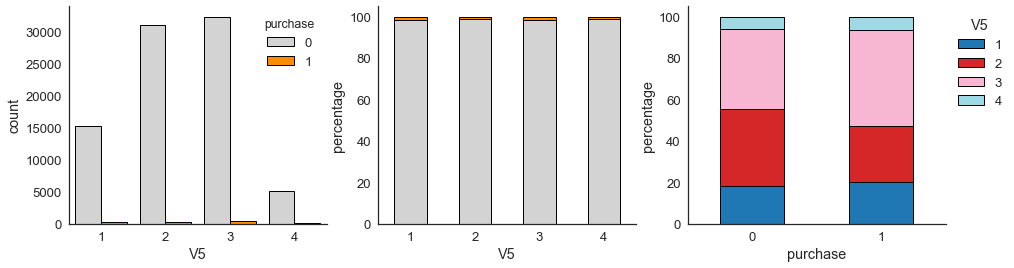

In [180]:
crossV5 = pd.DataFrame(pd.crosstab(data['V5'], data['purchase'], normalize="index")*100)
crossV5target = pd.DataFrame(pd.crosstab(data['V5'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V5'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V5", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV5.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV5target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V6,1,2,3,4
purchase,,,,
0,20764,20887,20917,20926
1,262,259,269,250


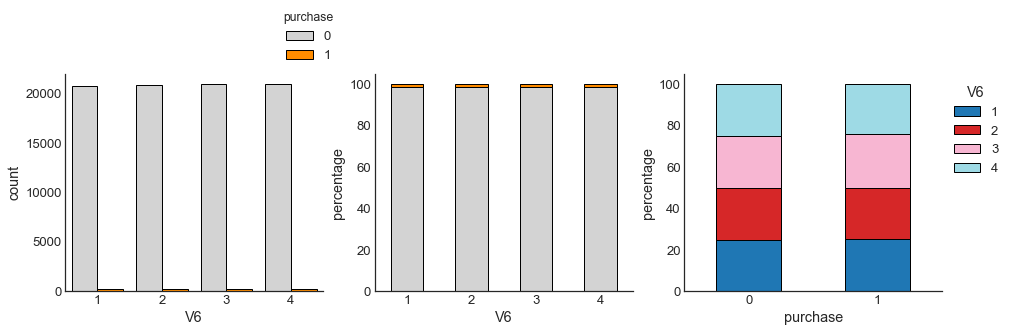

In [47]:
crossV6 = pd.DataFrame(pd.crosstab(data['V6'], data['purchase'], normalize="index")*100)
crossV6target = pd.DataFrame(pd.crosstab(data['V6'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V6'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V6", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
g1.legend_.set_bbox_to_anchor((0.8, 1))
sns.despine()
# percentage in each category
g2 = crossV6.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV6target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V7,1,2
purchase,,
0,24902,58592
1,315,725


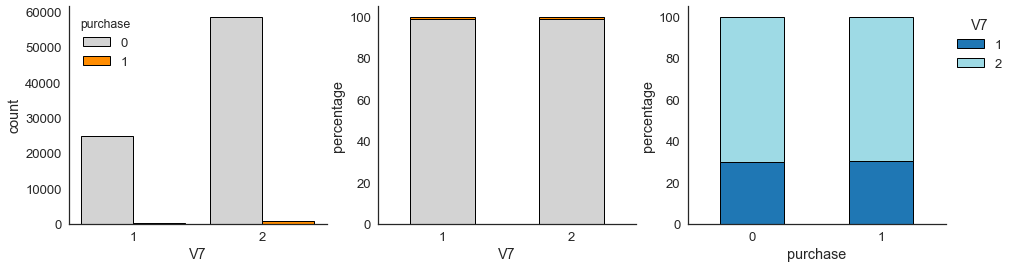

In [182]:
crossV7 = pd.DataFrame(pd.crosstab(data['V7'], data['purchase'], normalize="index")*100)
crossV7target = pd.DataFrame(pd.crosstab(data['V7'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V7'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V7", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'}, 
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV7.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV7target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

## Modeling

We will use the *purchase* column as the target that we want to predict. To quantify the performance of our models, we are going to split our dataset into training and testing subsets and use cross-validation to tune some of the models' parameters. The models that we are going to try are:

1. XGBoost model (boosting)
2. Random Forest model (bagging)

In [5]:
features = list(data.iloc[:,3:].select_dtypes(exclude='object').columns)
X = data[features]
y = data.purchase
Xtrain, Xtest, Ytrain, Ytest, Ttrain, Ttest = train_test_split(X, y, data.promotion, test_size=0.1, stratify=y, random_state=42)

To reduce the computational load a bit, I am going to downsample the training set before tuning the hyperparameters. After choosing the hyperparameters, the model will be retrained on all the training data, but to make my computer's life a little bit easier, I am going to tune the hyperparameters based on 20000 observations. I will only be removing the observations coming from people that did not purchase the product.

In [6]:
NoPurch = data.query('purchase == 0').index
commonTreat = list(set(NoPurch).intersection(Ttrain[Ttrain==1].index))
commonControl = list(set(NoPurch).intersection(Ttrain[Ttrain==0].index))
toDropTreat = np.random.choice(commonTreat, len(Ttrain[Ttrain==1])-20000, replace=False)
toDropControl = np.random.choice(commonControl, len(Ttrain[Ttrain==0])-20000, replace=False)
XhyperTreat = Xtrain[Ttrain==1].drop(toDropTreat)
XhyperControl = Xtrain[Ttrain==0].drop(toDropControl)
YhyperTreat = Ytrain[Ttrain==1].drop(toDropTreat)
YhyperControl = Ytrain[Ttrain==0].drop(toDropControl)

In [7]:
plotMethods.eda(XhyperTreat)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
V1,int64,20000,0,4,1.501100,0.866450,0.000000,3.000000,-0.667773,-0.001310
V2,float64,20000,0,19999,29.941329,4.988798,7.829609,48.777140,0.005640,-0.009079
V3,float64,20000,0,40,0.006085,0.996719,-1.684550,1.691984,-1.196660,0.001194
V4,int64,20000,0,2,1.683150,0.465260,1.000000,2.000000,-1.380170,-0.787380
V5,int64,20000,0,4,2.334550,0.841226,1.000000,4.000000,-0.745915,-0.074600
V6,int64,20000,0,4,2.505350,1.115945,1.000000,4.000000,-1.355140,-0.007052
V7,int64,20000,0,2,1.701250,0.457721,1.000000,2.000000,-1.226701,-0.879444


In [8]:
plotMethods.eda(XhyperControl)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
V1,int64,20000,0,4,1.487550,0.867976,0.000000,3.000000,-0.671659,0.023824
V2,float64,20000,0,19999,30.009997,4.973198,10.987478,50.375913,0.048780,-0.031476
V3,float64,20000,0,40,-0.007231,1.001885,-1.684550,1.691984,-1.206564,0.021989
V4,int64,20000,0,2,1.678450,0.467083,1.000000,2.000000,-1.416170,-0.764180
V5,int64,20000,0,4,2.335250,0.843738,1.000000,4.000000,-0.740183,-0.058745
V6,int64,20000,0,4,2.496150,1.118368,1.000000,4.000000,-1.360717,0.005243
V7,int64,20000,0,2,1.697850,0.459201,1.000000,2.000000,-1.257427,-0.861800


In [9]:
print("Number of purchases in XTrain Treatment: {}, in XTrain Controls: {}".format(len(Xtrain[(Ttrain==1) & (Ytrain==1)]),len(Xtrain[(Ttrain==0) & (Ytrain==1)])))

Number of purchases in XTrain Treatment: 656, in XTrain Controls: 280


Because our dataset is still **unbalanced**, instead of downsampling even more, we are going to use oversampling technique called **SMOTE**. SMOTE synthetically generates new data points belonging to the minority class (here, the customers that we should target).

In [10]:
numPipe = StandardScaler()
preproc = ColumnTransformer(transformers=[('num', numPipe, Xtrain.select_dtypes(include="number").columns)])

oversamp = SMOTE()

### 1. XGBoost model (boosting)

In [11]:
model = XGBClassifier()
xgbPipe = make_pipeline(preproc, oversamp, model)

In [12]:
def objective(trial, X, Y):
    
    xgbParams = {
        "xgbclassifier__n_estimators": 800, 
        "xgbclassifier__gamma": trial.suggest_float("xgbclassifier__gamma", 0, 0.4), 
        "xgbclassifier__alpha": trial.suggest_loguniform("xgbclassifier__alpha", 1e-3, 1e-1),
        "xgbclassifier__max_depth": trial.suggest_int("xgbclassifier__max_depth", 5, 10),
        "xgbclassifier__min_child_weight": trial.suggest_int("xgbclassifier__min_child_weight", 10, 60, 10), 
        "xgbclassifier__eta": trial.suggest_loguniform("xgbclassifier__eta", 1e-3, 1e-1)
    }
    xgbPipe.set_params(**xgbParams)
    
    scores = cross_val_score(xgbPipe, X, Y, scoring='neg_log_loss', cv=5)
    
    return np.mean(scores)

#### Treatment model

In [27]:
xgbStudyTreat = optuna.create_study(direction='maximize')
xgbStudyTreat.optimize(lambda trial: objective(trial, XhyperTreat, YhyperTreat), n_trials=100)

joblib.dump(xgbStudyTreat, 'xgb-tlearn-treat')  # save model

[I 2020-11-20 09:31:59,113] A new study created in memory with name: no-name-1c19a6e0-5028-4fed-a7c0-971d0b937eea
[I 2020-11-20 09:35:39,225] Trial 1 finished with value: -0.36873440749943254 and parameters: {'xgbclassifier__gamma': 0.030079409907497204, 'xgbclassifier__alpha': 0.05794797761034047, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 20, 'xgbclassifier__eta': 0.0055150168504547485}. Best is trial 1 with value: -0.36873440749943254.
[I 2020-11-20 09:37:22,062] Trial 2 finished with value: -0.16390897539763244 and parameters: {'xgbclassifier__gamma': 0.3432744517569496, 'xgbclassifier__alpha': 0.0346074509341762, 'xgbclassifier__max_depth': 9, 'xgbclassifier__min_child_weight': 50, 'xgbclassifier__eta': 0.09537885026352778}. Best is trial 2 with value: -0.16390897539763244.
[I 2020-11-20 09:38:51,568] Trial 3 finished with value: -0.34122804835073184 and parameters: {'xgbclassifier__gamma': 0.2848019907019995, 'xgbclassifier__alpha': 0.010036909212068488, 'x

['xgb-tlearn-treat']

In [99]:
xgbStudyTreat = joblib.load('xgb-tlearn-treat')
xgbStudyTreat.best_params

{'xgbclassifier__alpha': 0.002825225086693088,
 'xgbclassifier__eta': 0.08516370722486506,
 'xgbclassifier__gamma': 0.3317147725844474,
 'xgbclassifier__max_depth': 6,
 'xgbclassifier__min_child_weight': 10}

In [100]:
xgbPipeTreat = deepcopy(xgbPipe.set_params(**xgbStudyTreat.best_params))
xgbPipeTreat.fit(Xtrain[Ttrain==1],Ytrain[Ttrain==1])
YpredTreat = xgbPipeTreat.predict(Xtest[Ttest==1])
YprobsTreat = xgbPipeTreat.predict_proba(Xtest[Ttest==1])[:,1]
cm = confusion_matrix(Ytest[Ttest==1], YpredTreat) 

invalid value encountered in true_divide


<bound method Figure.tight_layout of <Figure size 1080x1440 with 9 Axes>>

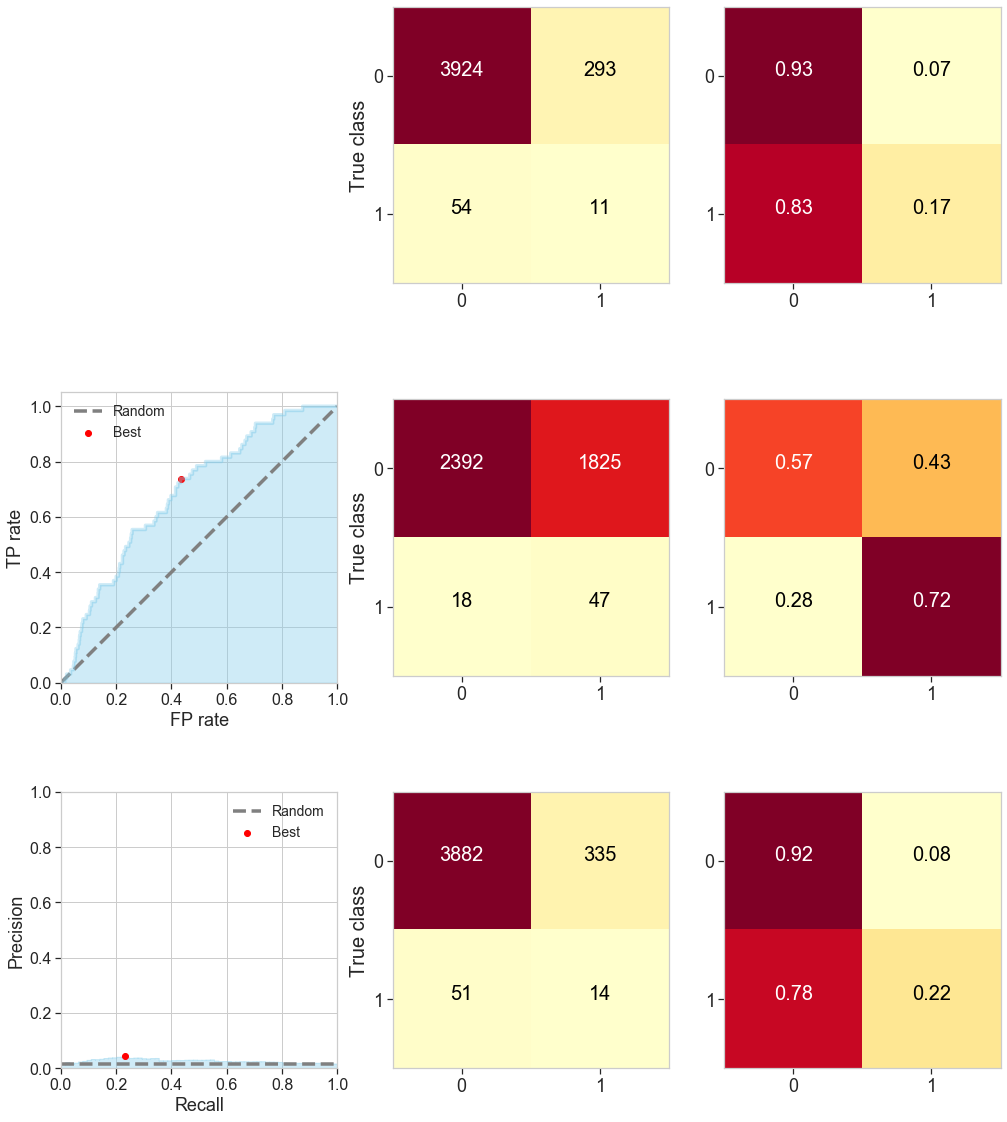

In [101]:
fig, axes = plt.subplots(3,3, figsize=(15,20), gridspec_kw={'hspace': 0.3})
axes[0,0].set_visible(False)
plotMethods.plotCM(cm, normalize=False, ax=axes[0,1], xlabel=False)
plotMethods.plotCM(cm, normalize=True, ax=axes[0,2], xlabel=False, ylabel=False)

_, bestROC = plotMethods.plotROC(Ytest[Ttest==1], YprobsTreat, ax=axes[1,0])
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==1], (YprobsTreat>bestROC).astype(int)),
                     normalize=False, ax=axes[1,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==1], (YprobsTreat>bestROC).astype(int)), 
                     normalize=True, ax=axes[1,2], xlabel=False, ylabel=False)

_, bestPR = plotMethods.plotPR(Ytest[Ttest==1], YprobsTreat, ax=axes[2,0])
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==1], (YprobsTreat>bestPR).astype(int)), 
                     normalize=False, ax=axes[2,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==1], (YprobsTreat>bestPR).astype(int)), 
                     normalize=True, ax=axes[2,2], xlabel=False, ylabel=False)

fig.tight_layout

In [102]:
plotMethods.metricsUplift(Ytest[Ttest==1], YprobsTreat, thresholds=[0.5, bestROC, bestPR], 
                           columns=['original', 'best ROC', 'best PR'])

,original,best ROC,best PR
AUC,0.55,0.65,0.57
Precission,0.04,0.03,0.04
Recall,0.17,0.72,0.22
F1,0.06,0.05,0.07
F2,0.10,0.11,0.11
Log Loss,0.27,0.27,0.27


In [103]:
plotMethods.metricsUplift(Ytrain[Ttrain==1], xgbPipeTreat.predict_proba(Xtrain[Ttrain==1])[:,1],
                           thresholds=[0.5, bestROC, bestPR], 
                           columns=['original', 'best ROC', 'best PR'])

,original,best ROC,best PR
AUC,0.58,0.66,0.59
Precission,0.05,0.03,0.05
Recall,0.23,0.76,0.26
F1,0.09,0.06,0.09
F2,0.14,0.13,0.15
Log Loss,0.27,0.27,0.27


All right, our model is performing very similarly on the training and dev sets. It has a really low precision, but should perform sufficiently good for our uplift calculation here.

To build the T-learner we need to now train a second model on the control dataset.

#### Control model

In [28]:
xgbStudyControl = optuna.create_study(direction='maximize')
xgbStudyControl.optimize(lambda trial: objective(trial, XhyperControl, YhyperControl), n_trials=100)

joblib.dump(xgbStudyControl, 'xgb-tlearn-control')  # save model

[I 2020-11-20 11:57:45,608] A new study created in memory with name: no-name-c184aa07-4061-4304-bd96-a6a9de985b26
[I 2020-11-20 11:59:03,912] Trial 1 finished with value: -0.23714106443832864 and parameters: {'xgbclassifier__gamma': 0.07010146808358893, 'xgbclassifier__alpha': 0.01800220533073334, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 40, 'xgbclassifier__eta': 0.010071256063208144}. Best is trial 0 with value: -0.11944189565543202.
[I 2020-11-20 12:00:11,613] Trial 2 finished with value: -0.24735976688414812 and parameters: {'xgbclassifier__gamma': 0.3421710992624173, 'xgbclassifier__alpha': 0.017108894264172583, 'xgbclassifier__max_depth': 9, 'xgbclassifier__min_child_weight': 50, 'xgbclassifier__eta': 0.0046733916722618025}. Best is trial 0 with value: -0.11944189565543202.
[I 2020-11-20 12:01:09,478] Trial 3 finished with value: -0.4532535433240235 and parameters: {'xgbclassifier__gamma': 0.18303126603474837, 'xgbclassifier__alpha': 0.001110303930356679, 

['xgb-tlearn-control']

In [104]:
xgbStudyControl = joblib.load('xgb-tlearn-control')
xgbStudyControl.best_params

{'xgbclassifier__alpha': 0.07841531232473746,
 'xgbclassifier__eta': 0.09967131643989034,
 'xgbclassifier__gamma': 0.01546244596964513,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__min_child_weight': 10}

In [108]:
xgbPipeControl = deepcopy(xgbPipe.set_params(**xgbStudyControl.best_params))
xgbPipeControl.fit(Xtrain[Ttrain==0],Ytrain[Ttrain==0])
YpredControl = xgbPipeControl.predict(Xtest[Ttest==0])
YprobsControl = xgbPipe.predict_proba(Xtest[Ttest==0])[:,1]
cm = confusion_matrix(Ytest[Ttest==0], YpredControl) 

invalid value encountered in true_divide


<bound method Figure.tight_layout of <Figure size 1080x1440 with 9 Axes>>

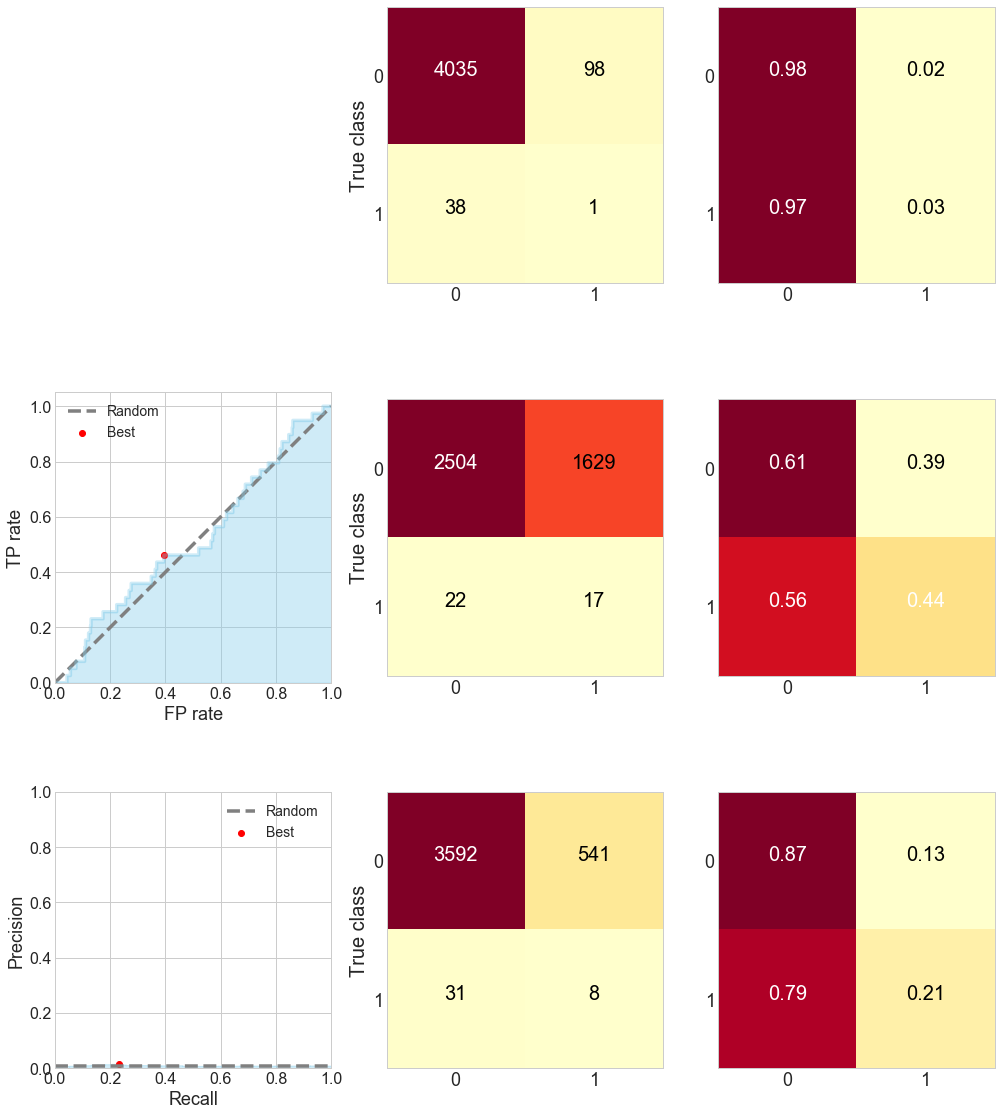

In [109]:
fig, axes = plt.subplots(3,3, figsize=(15,20), gridspec_kw={'hspace': 0.3})
axes[0,0].set_visible(False)
plotMethods.plotCM(cm, normalize=False, ax=axes[0,1], xlabel=False)
plotMethods.plotCM(cm, normalize=True, ax=axes[0,2], xlabel=False, ylabel=False)

_, bestROC = plotMethods.plotROC(Ytest[Ttest==0], YprobsControl, ax=axes[1,0])
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==0], (YprobsControl>bestROC).astype(int)),
                     normalize=False, ax=axes[1,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==0], (YprobsControl>bestROC).astype(int)), 
                     normalize=True, ax=axes[1,2], xlabel=False, ylabel=False)

_, bestPR = plotMethods.plotPR(Ytest[Ttest==0], YprobsControl, ax=axes[2,0])
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==0], (YprobsControl>bestPR).astype(int)), 
                     normalize=False, ax=axes[2,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==0], (YprobsControl>bestPR).astype(int)), 
                     normalize=True, ax=axes[2,2], xlabel=False, ylabel=False)

fig.tight_layout

In [110]:
plotMethods.metricsUplift(Ytest[Ttest==0], YprobsControl, thresholds=[0.5, bestROC, bestPR], 
                           columns=['original', 'best ROC', 'best PR'])

,original,best ROC,best PR
AUC,0.50,0.52,0.54
Precission,0.01,0.01,0.01
Recall,0.08,0.44,0.21
F1,0.02,0.02,0.03
F2,0.03,0.05,0.06
Log Loss,0.27,0.27,0.27


In [111]:
plotMethods.metricsUplift(Ytrain[Ttrain==0], xgbPipeControl.predict_proba(Xtrain[Ttrain==0])[:,1],
                           thresholds=[0.5, bestROC, bestPR], 
                           columns=['original', 'best ROC', 'best PR'])

,original,best ROC,best PR
AUC,0.55,0.65,0.57
Precission,0.04,0.01,0.03
Recall,0.12,0.67,0.21
F1,0.07,0.03,0.05
F2,0.09,0.06,0.09
Log Loss,0.23,0.23,0.23


Our control model has similar log-loss scores to the treated model, but performs worse in terms of other metrics. It seems to perform very similarly to random targeting. It could be worth it to try and further tune the hyperparameters or spend some time on feature engineering, but for now we will just keep going. 

To calculate the uplift score, we will now fit both of those models to our dev set and calculate the difference in probabilities predicted by the treatment and the control models.


In [112]:
Xuplift = Xtest.copy()
Xuplift['promotion'] = Ttest

xgbUp = xgbPipeTreat.predict_proba(Xtest)[:,1] - xgbPipeControl.predict_proba(Xtest)[:,1]
Xuplift['xgb_uplift'] = xgbUp

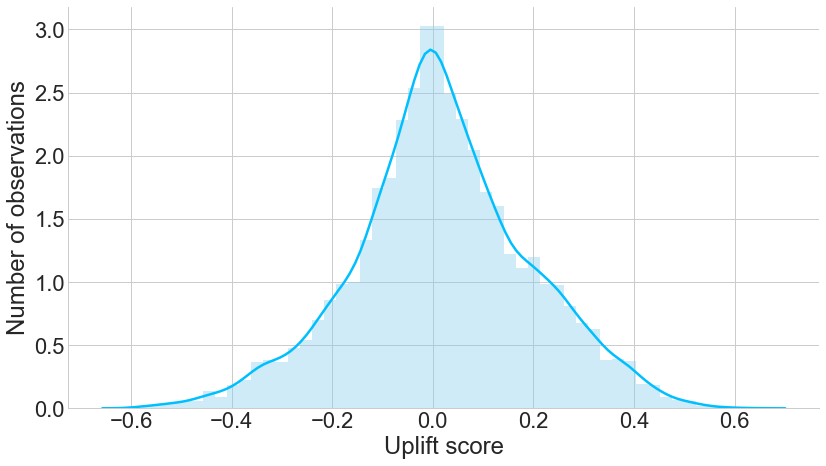

In [113]:
fig, ax = plt.subplots(figsize=(12,7))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
sns.distplot(xgbUp, kde_kws = {"color": "deepskyblue"}, hist_kws = {"color": "skyblue"}, ax=ax)
sns.despine()
plt.xlabel('Uplift score')
plt.ylabel('Number of observations')

plt.tight_layout()

The distribution of uplift seems to be centered around zero, slightly skewed towards positive values. It seems like quite a large proportion of people would not respond to our marketing at all. Importantly, the observations associated with the negative uplift tell us that targeting some people actually discourages them from buying the product. Those are the people we definitely do not want to target. 

How much should we trust this plot though? How do we know how good this T-learner model is? The distribution of uplift seems to be completely different from the one we have seen with our S-learners. Could training two separate models result in overall decrease in reliability here? 

Let's look at a comparison of the purchase rate between the targeted and not-targeted groups, in different ranges of the predicted uplift score. In the ranges with high uplift scores, we would expect to see larger differences between the two groups, while in those with lower uplift scores, we should have smaller differences.

Text(0, 0.5, 'True uplift')

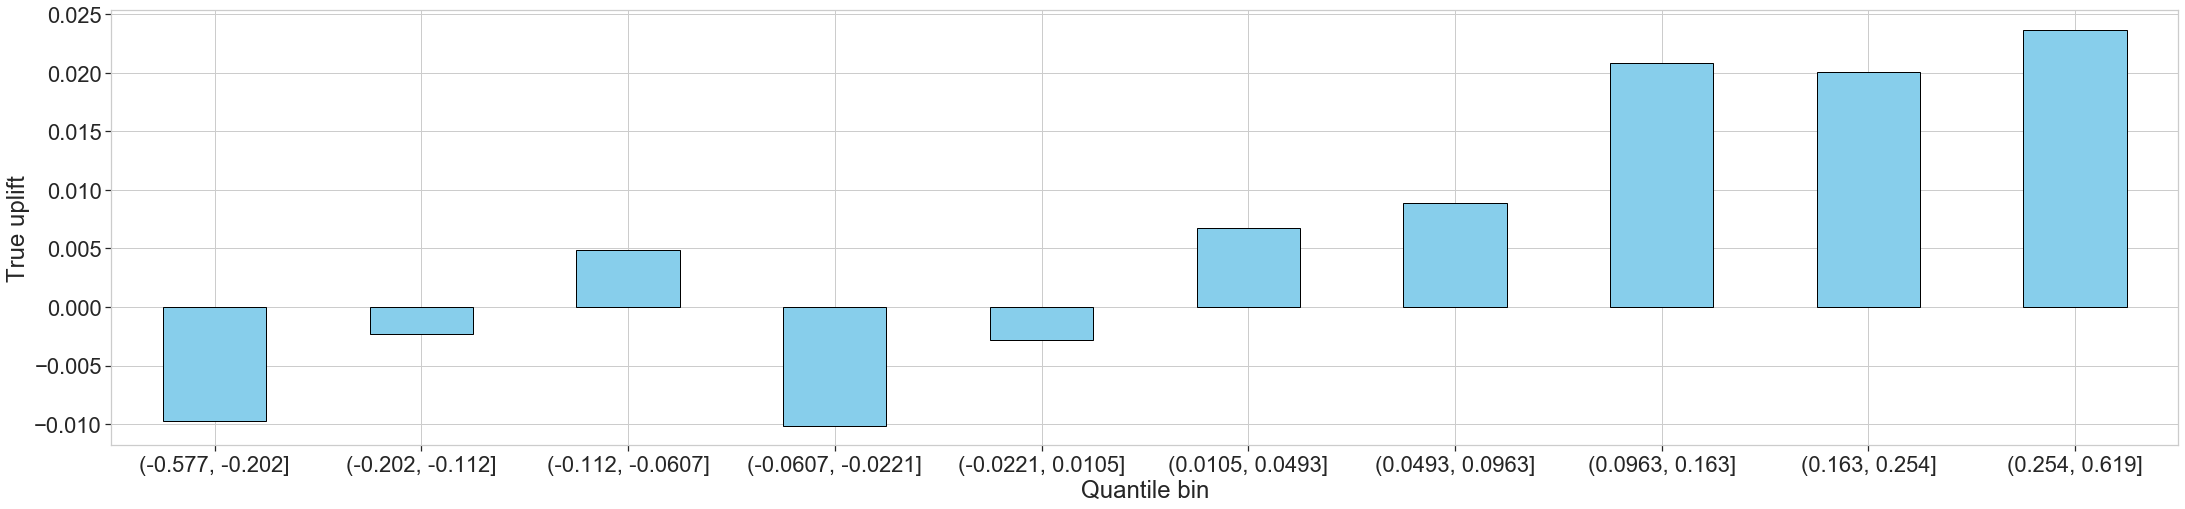

In [114]:
upliftQuant, upliftQuant_bins = pd.qcut(x=Xuplift['xgb_uplift'], q=10, retbins=True, duplicates='drop')
Xuplift['xgb_quant'] = upliftQuant
Xuplift['Y'] = Ytest
QuantTarget = Xuplift[Ttest==1].groupby('xgb_quant')['Y'].mean()
QuantControl = Xuplift[Ttest==0].groupby('xgb_quant')['Y'].mean()
quantUp = QuantTarget - QuantControl

fig, ax = plt.subplots(figsize=(33,8))
quantUp.plot(kind="bar", stacked=True, color="skyblue", edgecolor='black')
plt.xticks(rotation=0)
plt.xlabel('Quantile bin')
plt.ylabel('True uplift')

The uplift quantile chart shows that, for the most part, true uplift increases from lower score bins to higher ones, which is what we would expect to see if the model is working. So it appears our model can, at least to some extent, segment out customers who more readily respond to the marketing campaign. 

What else can we learn from the quantile chart? From analysis of the A/B testing we know the IIR is about 1%. The quantile chart we created with the validation set tells us that by targeting the top decile of the uplift scores, **we could potentially achieve a treatment effect of around 2%**. So twice the original one. The next few deciles appear to have larger treatment effects than our original IIR as well. It thus may make the most sense to **only target customers within the top 2-3 deciles** of uplift scores.

We can also see that the *sleeping dog effect* has some support from observations of the true uplift. The bottom score deciles, consisting entirely of negative scores, have a negative true uplift. So it appears that targeting the bottom 30% of the population, by uplift score, would actually have a negative impact on the business. 

Let's also check the cumulative gain plot and calculate our AUUC metric, so that we can compare this model to the other ones.

Text(0, 0.5, 'Cumulative gain')

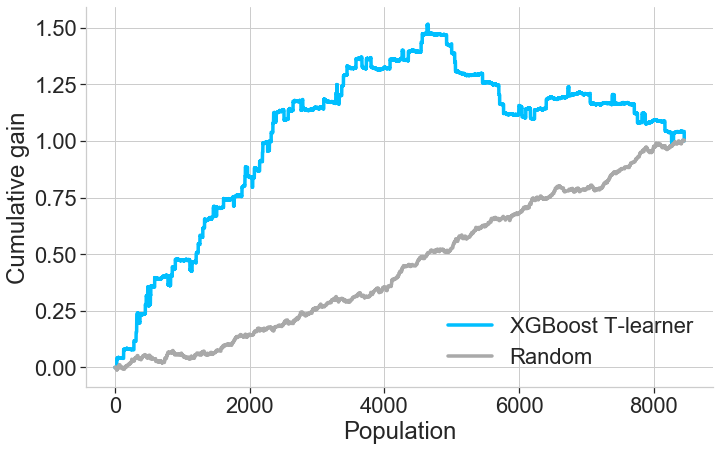

In [144]:
gain = get_cumgain(Xuplift[['xgb_uplift', 'Y', 'promotion']], outcome_col='Y', treatment_col='promotion', normalize=True)
gain.columns = ['XGBoost T-learner', 'Random']
fig, ax = plt.subplots(figsize=(10,7))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3.5})
sns.lineplot(data=gain, palette={'Random': 'darkgray', 'XGBoost T-learner': 'deepskyblue'}, dashes=False, ax=ax)
sns.despine()
plt.xlabel("Population")
plt.ylabel("Cumulative gain")

In [143]:
AUUC = auuc_score(Xuplift[['xgb_uplift', 'Y', 'promotion']], outcome_col='Y', treatment_col='promotion', normalize=True)
print("Random AUUC: {:.3f}\nXGBoost T-learner {:.3f}".format(AUUC[1], AUUC[0]))

Random AUUC: 0.447
XGBoost T-learner 1.030


Our uplift model performs much better than random targeting! Let's check what NIR and IIR we would generate if we targeted the first 3 deciles of our validation set. In order to check that we're going to discard people who were not targeted and did not buy the product from our validation set. This is due to the fact that we do not have ground truth scenario for how they would behave if we targeted them.

In [117]:
toDrop = Xuplift.query('promotion == 0 and Y == 0').index
NoPurchValid = Xuplift.drop(toDrop)
plotMethods.eda(NoPurchValid)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
V1,int64,4321,0,4,1.504050,0.866851,0,3,-0.668249,-0.005001
V2,float64,4321,0,4321,30.016632,5.052259,10.3895,49.7728,0.026512,0.011639
V3,float64,4321,0,40,0.013525,0.992774,-1.68455,1.69198,-1.198498,-0.006148
V4,int64,4321,0,2,1.669521,0.470440,1,2,-1.480809,-0.721025
V5,int64,4321,0,4,2.312428,0.838349,1,4,-0.767420,-0.069009
V6,int64,4321,0,4,2.503587,1.119709,1,4,-1.363726,-0.003037
V7,int64,4321,0,2,1.697755,0.459284,1,2,-1.258324,-0.861544
promotion,int64,4321,0,2,0.990974,0.094585,0,1,105.927902,-10.386475
xgb_uplift,float32,4321,0,4203,0.018070,0.176106,-0.57567,0.583535,0.227919,-0.016804
xgb_quant,category,4321,0,10,NaN,NaN,"(-0.577, -0.202]","(0.254, 0.619]",NaN,NaN


In [118]:
profit = plotMethods.incremental_profit_score(NoPurchValid['Y'], (NoPurchValid['xgb_uplift']>0.0963).astype(int))
IIR = plotMethods.IIRscore(NoPurchValid['Y'], (NoPurchValid['xgb_uplift']>0.0963).astype(int))
print("NIR: {:.2f}\nIIR {:.2f}%".format(profit, IIR*100))

NIR: 317.00
IIR 2.24%


The original A/B testing, targeted at random around 50% of the sample group, generating IIR of 1%. This uplift model targets a smaller proportion of population, generating 2.5 times higher IIR.

### 2. Random Forest Classifier (bagging)

In [119]:
model = RandomForestClassifier()

rfPipe = make_pipeline(preproc, oversamp, model)
rfParams = {"randomforestclassifier__n_estimators": [800], 
            "randomforestclassifier__class_weight": [{0: 1.0, 1: 1.0}, {0: 1.0, 1: 2.0}, {0: 0.1, 1: 1.0}], 
            "randomforestclassifier__max_depth": range(5,11,1), "randomforestclassifier__min_samples_leaf": [20, 50, 70, 100, 200, 500]
           }

rfStudy = GridSearchCV(rfPipe, param_grid=rfParams, scoring= 'neg_log_loss', cv=5, verbose=10)

#### Treatment model

In [ ]:
rfStudy.fit(XhyperTreat,YhyperTreat)

joblib.dump(rfStudy, 'rf-tlearn-treat')  # save model

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.576, total=  13.6s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.585, total=  13.1s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.6s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.584, total=  13.6s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.2s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.580, total=  13.7s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.9s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.585, total=  13.2s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.583, total=  12.9s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.587, total=  13.8s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.6min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.585, total=  13.0s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.580, total=  12.9s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.0min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.585, total=  14.4s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800 
[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800, score=-0.580, total=  13.9s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800 
[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800, score=-0.584, total= 

In [120]:
rfStudyTreat = joblib.load('rf-tlearn-treat')
rfStudyTreat.best_params_

{'randomforestclassifier__class_weight': {0: 1.0, 1: 1.0},
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__min_samples_leaf': 20,
 'randomforestclassifier__n_estimators': 800}

In [121]:
rfPipeTreat = deepcopy(rfPipe.set_params(**rfStudyTreat.best_params_))
rfPipeTreat.fit(Xtrain[Ttrain==1],Ytrain[Ttrain==1])
YpredTreat = rfPipeTreat.predict(Xtest[Ttest==1])
YprobsTreat = rfPipeTreat.predict_proba(Xtest[Ttest==1])[:,1]
cm = confusion_matrix(Ytest[Ttest==1], YpredTreat) 

<bound method Figure.tight_layout of <Figure size 1080x1440 with 9 Axes>>

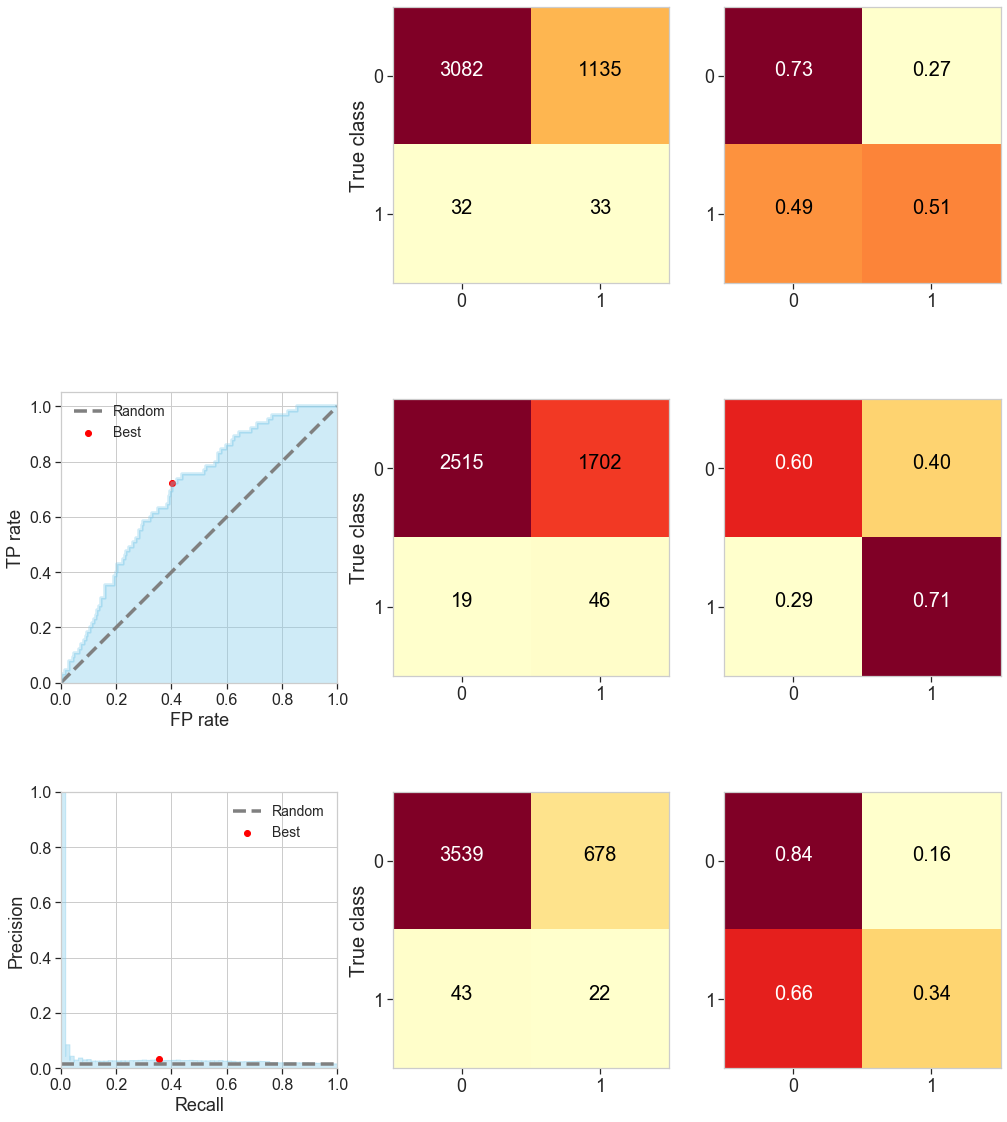

In [122]:
fig, axes = plt.subplots(3,3, figsize=(15,20), gridspec_kw={'hspace': 0.3})
axes[0,0].set_visible(False)
plotMethods.plotCM(cm, normalize=False, ax=axes[0,1], xlabel=False)
plotMethods.plotCM(cm, normalize=True, ax=axes[0,2], xlabel=False, ylabel=False)

_, bestROC = plotMethods.plotROC(Ytest[Ttest==1], YprobsTreat, ax=axes[1,0])
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==1], (YprobsTreat>bestROC).astype(int)),
                     normalize=False, ax=axes[1,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==1], (YprobsTreat>bestROC).astype(int)), 
                     normalize=True, ax=axes[1,2], xlabel=False, ylabel=False)

_, bestPR = plotMethods.plotPR(Ytest[Ttest==1], YprobsTreat, ax=axes[2,0])
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==1], (YprobsTreat>bestPR).astype(int)), 
                     normalize=False, ax=axes[2,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==1], (YprobsTreat>bestPR).astype(int)), 
                     normalize=True, ax=axes[2,2], xlabel=False, ylabel=False)

fig.tight_layout

In [123]:
plotMethods.metricsUplift(Ytest[Ttest==1], YprobsTreat, thresholds=[0.5, bestROC, bestPR], 
                           columns=['original', 'best ROC', 'best PR',])

,original,best ROC,best PR
AUC,0.62,0.65,0.59
Precission,0.03,0.03,0.03
Recall,0.51,0.71,0.34
F1,0.05,0.05,0.06
F2,0.12,0.11,0.11
Log Loss,0.46,0.46,0.46


In [127]:
plotMethods.metricsUplift(Ytrain[Ttrain==1], rfPipeTreat.predict_proba(Xtrain[Ttrain==1])[:,1],
                           thresholds=[0.5, bestROC, bestPR], 
                           columns=['original', 'best ROC', 'best PR'])

,original,best ROC,best PR
AUC,0.66,0.69,0.63
Precission,0.04,0.03,0.04
Recall,0.60,0.80,0.42
F1,0.07,0.06,0.08
F2,0.15,0.14,0.16
Log Loss,0.46,0.46,0.46


This model also performs simlarly on the training and dev datasets, indicating we are not overfitting. But the logloss score is quite a bit worse than for the XGBoost model.

What about the controls?

#### Control model

In [ ]:
rfStudy.fit(XhyperControl,YhyperControl)

joblib.dump(rfStudy, 'rf-tlearn-control')  # save model

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.576, total=  13.6s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.585, total=  13.1s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.6s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.584, total=  13.6s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.2s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.580, total=  13.7s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.9s remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=20, randomforestclassifier__n_estimators=800, score=-0.585, total=  13.2s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.583, total=  12.9s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.587, total=  13.8s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.6min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.585, total=  13.0s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.580, total=  12.9s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.0min remaining:    0.0s


[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=50, randomforestclassifier__n_estimators=800, score=-0.585, total=  14.4s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800 
[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800, score=-0.580, total=  13.9s
[CV] randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800 
[CV]  randomforestclassifier__class_weight={0: 1.0, 1: 1.0}, randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=70, randomforestclassifier__n_estimators=800, score=-0.584, total= 

In [128]:
rfStudyControl = joblib.load('rf-tlearn-control')
rfStudyControl.best_params_

{'randomforestclassifier__class_weight': {0: 1.0, 1: 1.0},
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__min_samples_leaf': 20,
 'randomforestclassifier__n_estimators': 800}

In [129]:
rfPipeControl = deepcopy(rfPipe.set_params(**rfStudyControl.best_params_))
rfPipeControl.fit(Xtrain[Ttrain==0],Ytrain[Ttrain==0])
YpredControl = rfPipeControl.predict(Xtest[Ttest==0])
YprobsControl = rfPipeControl.predict_proba(Xtest[Ttest==0])[:,1]
cm = confusion_matrix(Ytest[Ttest==0], YpredControl) 

invalid value encountered in true_divide


<bound method Figure.tight_layout of <Figure size 1080x1440 with 9 Axes>>

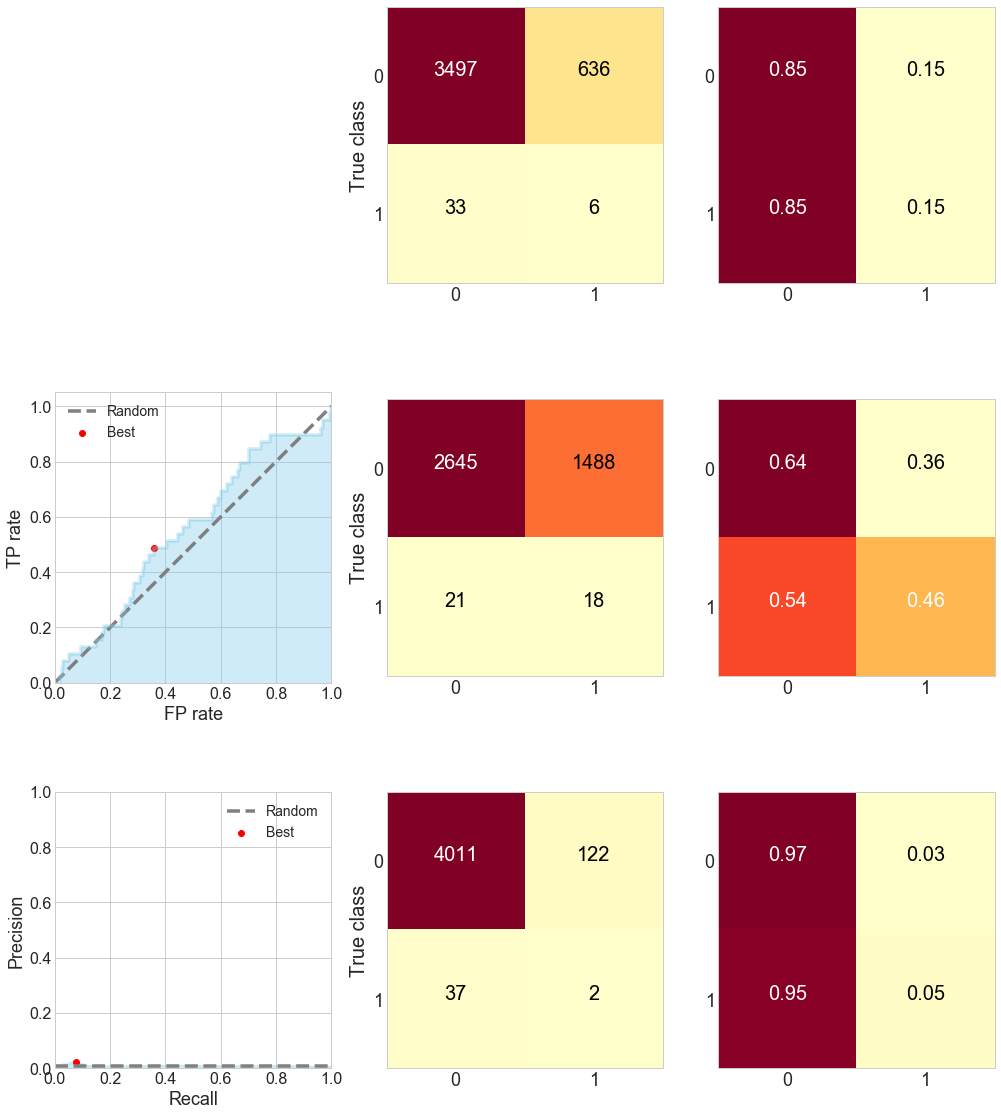

In [130]:
fig, axes = plt.subplots(3,3, figsize=(15,20), gridspec_kw={'hspace': 0.3})
axes[0,0].set_visible(False)
plotMethods.plotCM(cm, normalize=False, ax=axes[0,1], xlabel=False)
plotMethods.plotCM(cm, normalize=True, ax=axes[0,2], xlabel=False, ylabel=False)

_, bestROC = plotMethods.plotROC(Ytest[Ttest==0], YprobsControl, ax=axes[1,0])
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==0], (YprobsControl>bestROC).astype(int)),
                     normalize=False, ax=axes[1,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==0], (YprobsControl>bestROC).astype(int)), 
                     normalize=True, ax=axes[1,2], xlabel=False, ylabel=False)

_, bestPR = plotMethods.plotPR(Ytest[Ttest==0], YprobsControl, ax=axes[2,0])
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==0], (YprobsControl>bestPR).astype(int)), 
                     normalize=False, ax=axes[2,1], xlabel=False)
plotMethods.plotCM(confusion_matrix(Ytest[Ttest==0], (YprobsControl>bestPR).astype(int)), 
                     normalize=True, ax=axes[2,2], xlabel=False, ylabel=False)

fig.tight_layout

In [131]:
plotMethods.metricsUplift(Ytest[Ttest==0], YprobsControl, thresholds=[0.5, bestROC, bestPR], 
                           columns=['original', 'best ROC', 'best PR',])

,original,best ROC,best PR
AUC,0.50,0.55,0.51
Precission,0.01,0.01,0.02
Recall,0.15,0.46,0.05
F1,0.02,0.02,0.02
F2,0.04,0.05,0.04
Log Loss,0.41,0.41,0.41


In [132]:
plotMethods.metricsUplift(Ytrain[Ttrain==0], rfPipeControl.predict_proba(Xtrain[Ttrain==0])[:,1],
                           thresholds=[0.5, bestROC, bestPR], 
                           columns=['original', 'best ROC', 'best PR'])

,original,best ROC,best PR
AUC,0.61,0.63,0.56
Precission,0.02,0.01,0.04
Recall,0.36,0.61,0.14
F1,0.03,0.02,0.06
F2,0.07,0.06,0.09
Log Loss,0.40,0.40,0.40


Let's calculate our uplift now

In [133]:
rfUp = rfPipeTreat.predict_proba(Xtest)[:,1] - rfPipeControl.predict_proba(Xtest)[:,1]
Xuplift['rf_uplift'] = rfUp

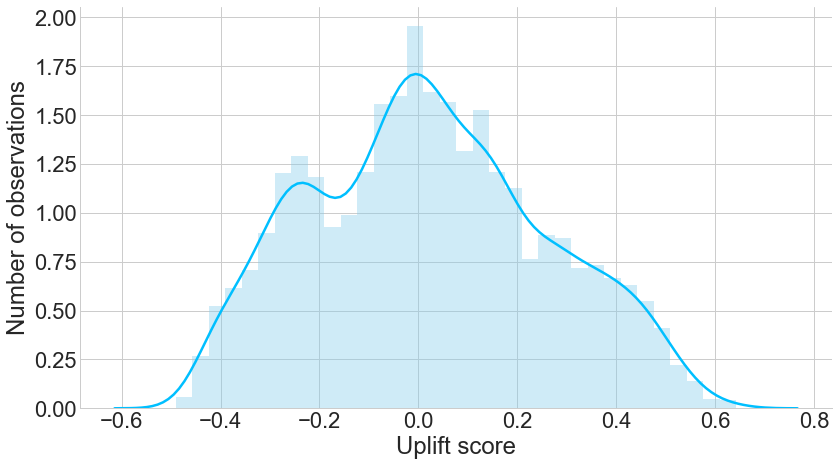

In [134]:
fig, ax = plt.subplots(figsize=(12,7))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
sns.distplot(rfUp, kde_kws = {"color": "deepskyblue"}, hist_kws = {"color": "skyblue"}, ax=ax)
sns.despine()
plt.xlabel('Uplift score')
plt.ylabel('Number of observations')

plt.tight_layout()

Again, the distribution of uplift is centered around zero, slightly skewed to the right, with a relatively large proportion of sleeping dogs.

Let's look at a our quantile and cumulative gain plots to try and evaluate this model.

Text(0, 0.5, 'True uplift')

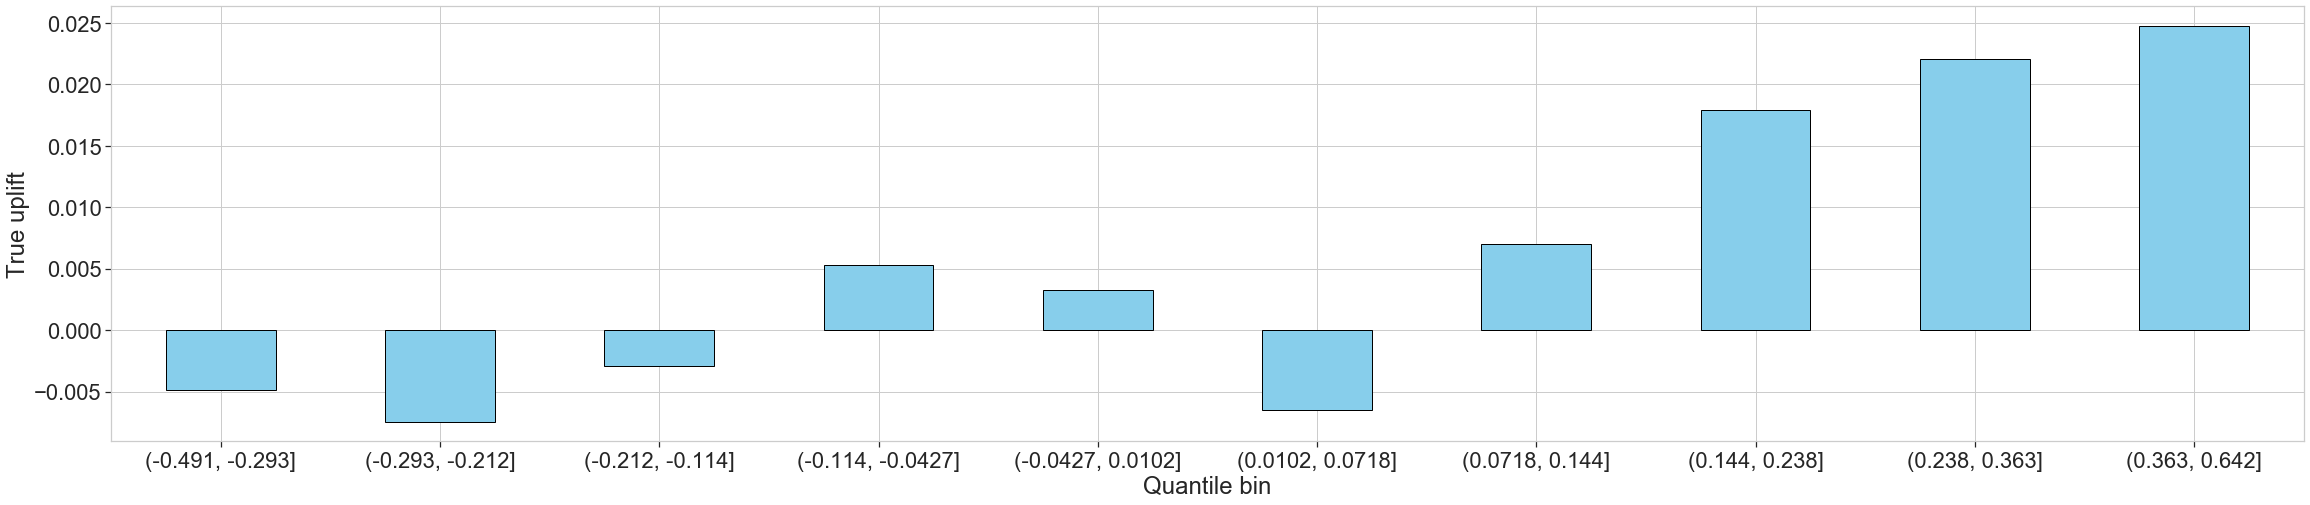

In [135]:
upliftQuant, upliftQuant_bins = pd.qcut(x=Xuplift['rf_uplift'], q=10, retbins=True, duplicates='drop')
Xuplift['rf_quant'] = upliftQuant
Xuplift['Y'] = Ytest
QuantTarget = Xuplift.query('promotion == 1').groupby('rf_quant')['Y'].mean()
QuantControl = Xuplift.query('promotion == 0').groupby('rf_quant')['Y'].mean()
quantUp = QuantTarget - QuantControl

fig, ax = plt.subplots(figsize=(35,8))
quantUp.plot(kind="bar", stacked=True, color="skyblue", edgecolor='black')
plt.xticks(rotation=0)
plt.xlabel('Quantile bin')
plt.ylabel('True uplift')

Should we target the first 3 quantiles?

Let's also check the cumulative gain plot and calculate our AUUC metric, so that we can compare this model to the other ones.

Text(0, 0.5, 'Cumulative gain')

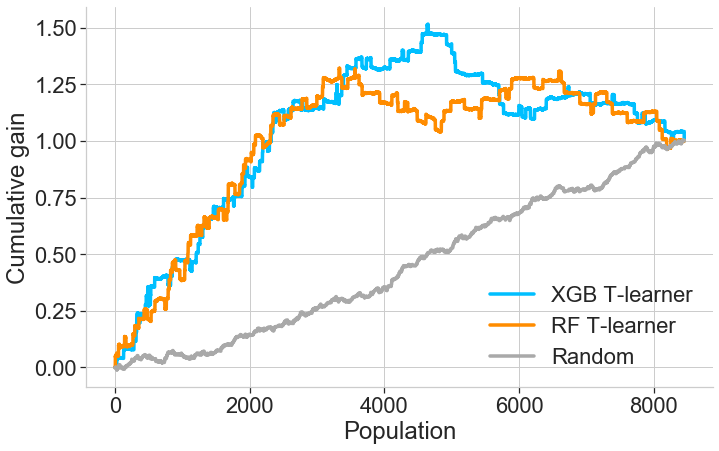

In [142]:
gain = get_cumgain(Xuplift[['xgb_uplift','rf_uplift', 'Y', 'promotion']], outcome_col='Y', treatment_col='promotion', normalize=True)
gain.columns = ['XGB T-learner', 'RF T-learner', 'Random']
fig, ax = plt.subplots(figsize=(10,7))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3.5})
sns.lineplot(data=gain, palette={'Random': 'darkgray', 'XGB T-learner': 'deepskyblue', 'RF T-learner': 'darkorange'}, dashes=False, ax=ax)
sns.despine()
plt.xlabel("Population")
plt.ylabel("Cumulative gain")

In [140]:
AUUC = auuc_score(Xuplift[['xgb_uplift','rf_uplift', 'Y', 'promotion']], outcome_col='Y', treatment_col='promotion', normalize=True)
print("Random AUUC: {:.3f}\nXGB T-learner {:.3f}\nRF T-learner {:.3f}".format(AUUC[2], AUUC[0], AUUC[1]))

Random AUUC: 0.447
XGB T-learner 1.030
RF T-learner 0.993


Our uplift model performs  better than random targeting, and slightly worse than the XGBoost-based S-learner.

In [139]:
profit = plotMethods.incremental_profit_score(NoPurchValid['Y'], (NoPurchValid['rf_uplift']>0.144).astype(int))
IIR = plotMethods.IIRscore(NoPurchValid['Y'], (NoPurchValid['rf_uplift']>0.144).astype(int))
print("NIR: {:.2f}\nIIR {:.2f}%".format(profit, IIR*100))

NIR: 325.00
IIR 2.30%


RF-based T-learner it gives us a slightly lower NIR and IIR than the XGBoost-based T-learner. Before we get to making any predictions on the the test dataset though, let's see how the remaining uplift modeling approaches are doing:


1. [Traditional predictive model](./1.Classical-predictive-models.ipynb) 
2. [S-learner model](./2.S-leraner.ipynb)
3. Direct uplift modeling